In [1]:
import os

import cv2
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
dir_path = os.path.join('Words')
# Root directory for all the images

In [ ]:
def get_file_path(file_name):
    # For each line in the words.txt, get_file_path returns the corresponding file path of that image in the location
    path = 'Words'
    destination = file_name[0]
    path = os.path.join(path, destination)
    for i in range(1, len(file_name)):
        destination = destination + "-" + file_name[i]
        path = os.path.join(path, destination)
    
    path = path + '.png'
    return (path)

img_paths  = []
img_labels = []   #words

with open('words.txt') as labels_file:
    for line in labels_file:

        if line[0] == "#":
            continue
            
        else:
            label = line.split(' ')[-1].strip('\n')
            file_name = line.split(' ')[0].split('-')
            file_name[2] = file_name[2]+'-'+file_name[3]
            file_name.pop()
            
            path = get_file_path(file_name)
            
            img_paths.append(path)
            img_labels.append(label)
            
print ('Total number of words {}'.format(len(img_labels)))

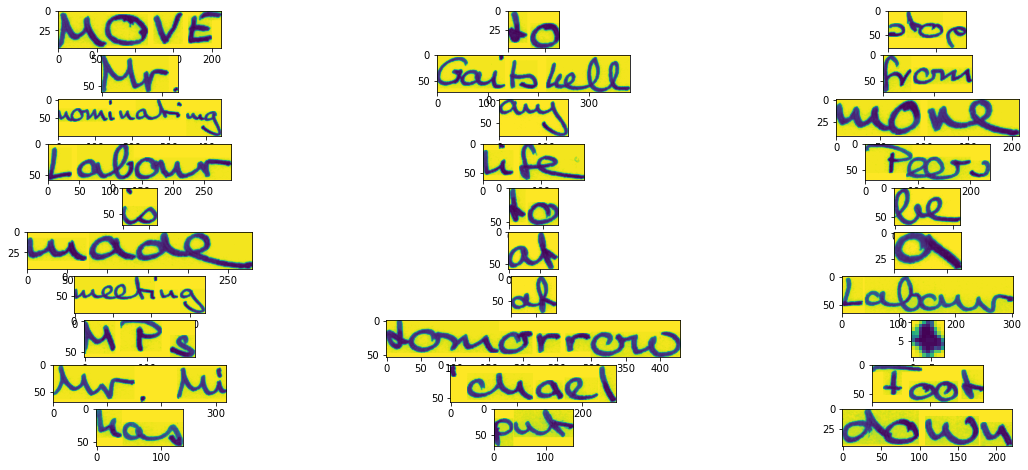

<Figure size 720x432 with 0 Axes>

In [4]:
# trans = {  
#     DO IMAGE TRANSFORMATION HERE
# }

# To see the effect of transformations on an image, run this code.

fig = plt.figure(figsize=(20, 8))
columns = 3
rows = 10
for i in range(1, rows*columns+1):  #for each index
    img = Image.open(img_paths[i])
    img = np.asarray(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()
fig = plt.figure(figsize=(10, 6))

In [5]:
# 20 most Common Words list
word_count = defaultdict(int)

for word in img_labels:
    word_count[word] += 1
    
common_words_counts = Counter(word_count).most_common(20)

common_words = list(list(zip(*common_words_counts))[0])

print (common_words)

['the', ',', '.', 'of', 'to', 'and', 'a', 'in', '"', 'was', 'that', 'is', 'he', 'for', "'", 'with', 'I', 'had', 'be', 'his']


In [6]:
# We train the model for not common words.
not_common_paths_labels = []

for i, label in enumerate(img_labels):
    if label not in common_words:
        not_common_paths_labels.append((img_paths[i], label))
        
not_common_paths_labels[1:10]

[('Words\\a01\\a01-000u\\a01-000u-00-01.png', 'MOVE'),
 ('Words\\a01\\a01-000u\\a01-000u-00-03.png', 'stop'),
 ('Words\\a01\\a01-000u\\a01-000u-00-04.png', 'Mr.'),
 ('Words\\a01\\a01-000u\\a01-000u-00-05.png', 'Gaitskell'),
 ('Words\\a01\\a01-000u\\a01-000u-00-06.png', 'from'),
 ('Words\\a01\\a01-000u\\a01-000u-01-00.png', 'nominating'),
 ('Words\\a01\\a01-000u\\a01-000u-01-01.png', 'any'),
 ('Words\\a01\\a01-000u\\a01-000u-01-02.png', 'more'),
 ('Words\\a01\\a01-000u\\a01-000u-01-03.png', 'Labour')]

**Making training data and testing data**

In [7]:
# Making of training images and testing images

random.shuffle(not_common_paths_labels)

train_len = int(0.7 * len(not_common_paths_labels))
test_len = len(not_common_paths_labels) - train_len

train_paths_labels = not_common_paths_labels[0:train_len]
test_paths_labels = not_common_paths_labels[train_len:]

train_paths_labels[0:2]

[('Words\\d06\\d06-041\\d06-041-04-06.png', 'night'),
 ('Words\\g06\\g06-042d\\g06-042d-04-02.png', 'homoeopathy')]

**Finding Ns and creating labels index map**

Labels index map will be useful in creating target matrix.

In [168]:
unique_characters = list()
for i, label in enumerate(img_labels):
    for char in label:
        if char not in unique_characters:
            unique_characters.append(char)
            
unique_characters.sort()
Ns = len(unique_characters)

labels_pos_map = {}
for i, char in enumerate(unique_characters):
    labels_pos_map[char] = i
    
print (labels_pos_map['a'], labels_pos_map['b'])

52 53


In [170]:
train_imgs_ts = list()
train_imgs_bs = list()
train_labels = list()
train_n = list()

count = 0
width, height = 128, 32

for path_label in train_paths_labels:
    n = len(path_label[1])
    img = cv2.imread(path_label[0])
    if img is not None:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        img_ts = cv2.resize(img, (width, height)).astype(np.float32).reshape(1, 32, 128, 1)
        train_imgs_ts.append(img_ts)
        
        img_bs = cv2.resize(img, (16*n, height)).astype(np.float32)
        shape = img_bs.shape
        img_bs = img_bs.reshape((1, shape[0], shape[1], 1))
        train_imgs_bs.append(img_bs)
        
        train_labels.append(path_label[1])
        train_n.append(n)
        count += 1
    
    if count == 500:   #to load all the images comment this line and lines containing count
        #Breaking at count = 100 will only use 100 images for training
        break
        
test_imgs_ts = list()
test_imgs_bs = list()
test_labels = list()
test_n = list()

count = 0
width, height = 128, 32

for path_label in test_paths_labels:
    n = len(path_label[1])
    img = cv2.imread(path_label[0])
    if img is not None:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        img_ts = cv2.resize(img, (width, height)).astype(np.float32).reshape(1, 32, 128, 1)
        test_imgs_ts.append(img_ts)
        
        img_bs = cv2.resize(img, (16*n, height)).astype(np.float32)
        shape = img_bs.shape
        img_bs = img_bs.reshape((1, shape[0], shape[1], 1))
        test_imgs_bs.append(img_bs)
        
        test_labels.append(path_label[1])
        test_n.append(n)
        count += 1
    
    if count == 100:   #to load all the images comment this line and lines containing count
        #Breaking at count = 10 will only use 10 images for testing
        break

In [171]:
print (len(train_imgs_ts) - len(test_imgs_ts))
print (len(train_imgs_bs) - len(test_imgs_bs))
print (len(train_labels) - len(test_labels))
print (len(train_n) - len(test_n))

400
400
400
400


In [132]:
def build_top_stream():
    input_shape = (32, 128, 1)
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024))
    return (model)

ts_model = build_top_stream()

#print (ts_model.summary())


In [133]:
# Image should be of shape 32 X 128 N. To do this, find n by looking at the label size. Then, the images are in train_imgs
# in numpy format. Make it as cv2, resize it, then convert back to np array. In real time, the n value is given by Length CNN.

# Data Format: NHWC
def build_bottom_stream():
    
    model = None
    model = tf.keras.Sequential()
    input_shape = (32, None, 1)
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3),  padding='same'))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3),  padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(layers.Conv2D(filters=256, kernel_size=(3, 3),  padding='same'))
    model.add(layers.Conv2D(filters=256, kernel_size=(3, 3),  padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(layers.Conv2D(filters=512, kernel_size=(3, 3),  padding='same'))
    model.add(layers.Conv2D(filters=512, kernel_size=(3, 3),  padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    padding = [[0, 0], [0, 0], [2, 2], [0, 0]]   
    model.add(layers.Conv2D(filters=1024, kernel_size=(4, 4), padding=padding))
    
    return (model)


bs_model = build_bottom_stream()



In [13]:
idx = 10
img = train_imgs_ts[idx]
ts_o = ts_model(img)

img = train_imgs_bs[idx]
bs_o = bs_model(img)
print (bs_o.shape)
# Here, a padding layer has to be added.

(1, 1, 13, 1024)


The outputs of top stream and bottom stream ar ts_o and bs_o. The task now is to combine both these outputs. Do Tile Add, followed by a ReLU and then a fully connected layer of size Ns. This gives a output of size (2N + 1)  * Ns. From these (2N + 1) * Ns symbols, 2N + 1 predictions are chosen. Requiring more clarity on choosing the 2n + 1 predictions. Ns is the total number of lexicon symbols in the data.

**Combining ts_o and bs_o**

**Is this the right way to do Tile Add?**

In [14]:
combined_o = bs_o + ts_o   # o for output, bs_o - bottom stream output, ts_o - combines stream output
combined_o = tf.nn.relu(combined_o)
combined_o.shape

TensorShape([1, 1, 13, 1024])

**Middle layer**

In [15]:
ms_model = None #Middle stream i.e the final stream

ms_model = tf.keras.Sequential()
ms_model.add(layers.Dense(Ns, input_shape = (None, None, 1024), activation=tf.nn.relu))

In [16]:
out = ms_model(combined_o)

out = tf.reshape(out, (out.shape[2], out.shape[3]))
print (out.shape)

(13, 78)


Now the output is of size (2N + 1) * Ns. For each of the 2N + 1 places, we choose one of the symbols. 

In [17]:
actual_word = train_labels[idx]

In [18]:
predicted_word = list()
for i in range(1, len(out), 2):
    predicted_word.append(labels[np.argmax(out[i])])

predicted_word = ''.join(predicted_word)

print (actual_word, predicted_word)

noting ACAAAY


**Loss value**

In [148]:
def get_character_error_rate(word1, word2):
    rows = len(word1) + 1
    cols = len(word2) + 1
    error_matrix = [[0 for i in range(cols)] for j in range(rows)]

    for i in range(len(error_matrix[0])):
        error_matrix[0][i] = i

    for i in range(len(error_matrix[0])):
        error_matrix[i][0] = i

    for i in range(1, rows):
        for j in range(1, cols):
            a = error_matrix[i-1][j] + 1
            b = error_matrix[i][j-1] + 1
            if word1[i-1] == word2[j-1]:
                c = error_matrix[i-1][j-1]
            else:
                c = error_matrix[i-1][j-1] + 2
            error_matrix[i][j] = min(a, b, c)
            
    return (error_matrix[rows-1][cols-1])

print (get_character_error_rate('aaaa', 'bbbb'))  #8
print (get_character_error_rate('aaaa', 'bbaa'))

def norm_loss(out, target):
    return (tf.norm(target - out))

8
4


**Defining optimizer**

In [21]:
optimizer = tf.keras.optimizers.RMSprop()

In [22]:
# The below is one iteration.

idx = 10
img_ts = train_imgs_ts[idx]
img_bs = train_imgs_bs[idx]
actual_word = train_labels[idx]

img_ts = tf.convert_to_tensor(img_ts)  #top stream input
img_bs = tf.convert_to_tensor(img_bs)  # bottom stream input

with tf.GradientTape(persistent=True) as tape:
    
    # ms_model - middle stream model, ts - top stream model, bs_model - bottom stream model
    out = ms_model(ts_model(img_ts) + bs_model(img_bs))
    out = tf.reshape(out, (out.shape[2], out.shape[3]))
    
    predicted_word = list()
    for i in range(1, len(out), 2):
        predicted_word.append(labels[np.argmax(out[i])])
    predicted_word = ''.join(predicted_word)

    print (actual_word, predicted_word)

    target = np.zeros(out.shape)
    for i in range(1, out.shape[0], 2):
        char = actual_word[(i - 1)//2]  # Shape of out is 2n 
        pos = labels_pos_map[char]
        target[i][pos] = 1.0
        
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    # loss = get_character_error_rate(actual_word, predicted_word)    ->  Not able to construct gradients using this method
    loss = norm_loss(target, out)


noting


**Finding gradient and back progpagating**

In [129]:
grads_ms = tape.gradient(loss, ms_model.trainable_weights)
grads_ts = tape.gradient(loss, ts_model.trainable_weights)
grads_bs = tape.gradient(loss, bs_model.trainable_weights)

optimizer.apply_gradients(zip(grads_ms, ms_model.trainable_weights))
optimizer.apply_gradients(zip(grads_bs, bs_model.trainable_weights))
optimizer.apply_gradients(zip(grads_ts, ts_model.trainable_weights))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=20019>

During training, we will work on minimising the loss. During testing, how to measure accuracy? Can we have accuracy as number of correct character predictions by total number of characters in percentage? Or Number of words correctly predicted by total number of words predicted (percentage) ?

### Training

In [ ]:
epochs = 100

loss_over_epochs = list()
character_error_rate = list()

for epoch in range(epochs):
    epoch_loss = 0
    cer = 0
    
    for idx in range(len(train_imgs_ts)):
        img_ts = tf.convert_to_tensor(train_imgs_ts[idx])  #top stream input
        img_bs = tf.convert_to_tensor(train_imgs_bs[idx])  # bottom stream input
        actual_word = train_labels[idx]
        
        with tf.GradientTape(persistent=True) as tape:
    
            # ms_model - middle stream model, ts - top stream model, bs_model - bottom stream model
            out = ms_model(ts_model(img_ts) + bs_model(img_bs))
            out = tf.reshape(out, (out.shape[2], out.shape[3]))
    
            predicted_word = list()
            for i in range(1, len(out), 2):
                predicted_word.append(labels[np.argmax(out[i])])
            predicted_word = ''.join(predicted_word)

            # print (actual_word, predicted_word)
            # loss = get_character_error_rate(actual_word, predicted_word)    ->  Not able to construct gradients using this method
            
            #Note: Shape of target depends on output shape.
            target = np.zeros(out.shape)   
            for i in range(1, out.shape[0], 2):
                char = actual_word[(i - 1)//2]  # Shape of out is 2n 
                pos = labels_pos_map[char]
                target[i][pos] = 1.0
            target = tf.convert_to_tensor(target, dtype=tf.float32)
            
            loss = norm_loss(target, out)
            
        grads_ms = tape.gradient(loss, ms_model.trainable_weights)
        grads_ts = tape.gradient(loss, ts_model.trainable_weights)
        grads_bs = tape.gradient(loss, bs_model.trainable_weights)

        optimizer.apply_gradients(zip(grads_ms, ms_model.trainable_weights))
        optimizer.apply_gradients(zip(grads_bs, bs_model.trainable_weights))
        optimizer.apply_gradients(zip(grads_ts, ts_model.trainable_weights))
        
        epoch_loss += loss
        cer += get_character_error_rate(actual_word, predicted_word)
    print ('Epoch {} CER {}'.format(epoch, cer))
    epoch_loss = int(epoch_loss)
    if (epoch % 10 == 0):
        print ('Epoch Loss {}  CER {}'.format(epoch_loss, cer))
        
    loss_over_epochs.append(epoch_loss)
    character_error_rate.append(cer)
    

Epoch 0 CER 4910
Epoch Loss 1110  CER 4910
Epoch 1 CER 4910
Epoch 2 CER 4910
Epoch 3 CER 4910
Epoch 4 CER 4910
Epoch 5 CER 4910


In [ ]:
loss_over_epochs

### Testing

In [ ]:
# Accuracy is calculated as number of correctly predicted characters  over total number of predicted characters.
# The other possible accuracy which we can use is number of correctly predicted words by total no. of words. But this 
# will give a very low result at the start and hence not used here.

In [ ]:
total_characters = 0
correct_prediction = 0

for idx in range(len(test_imgs_ts)):
    img_ts = tf.convert_to_tensor(test_imgs_ts[idx])  #top stream input
    img_bs = tf.convert_to_tensor(test_imgs_bs[idx])  # bottom stream input
    actual_word = test_labels[idx]

    out = ms_model(ts_model(img_ts) + bs_model(img_bs))
    out = tf.reshape(out, (out.shape[2], out.shape[3]))

    predicted_word = list()
    for i in range(1, len(out), 2):
        predicted_word.append(labels[np.argmax(out[i])])
    predicted_word = ''.join(predicted_word)

    total_characters += len(actual_word)
    for i in range(len(actual_word)):
        if actual_word[i] == predicted_word[i]:
            correct_prediction += 1
    
print ("Character wise accuracy {}".format(correct_prediction*100 / total_characters))


**To Do**
   
    Make it to mini-batch method. Training will be more efficient. For mini batch, optimizer should be changed because RMSprop does not work with mini-batch method because of the reasons here(https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf).

Possible problems which can occur:

    Target may not be computed in the right way.
    Optimizer might not converge. 
    The choice of loss function might be bad.
    The 'n' value is taken from the actual word. If we predict the 'n' value and if it is different from actual word, what will happen during the loss computation.
    Shape of target depends on output shape - target should depend on actual word shape.
    
Remedies: (To be done)

    Learn more about loss functions  - look on RMSprop optimizer
    Tweak and modify the model.
    Check for precision and recall as measures instead of accuracy/

To Read:
    https://ai.googleblog.com/2019/03/rnn-based-handwriting-recognition-in.html
    https://github.com/lysecret2/Pytorch-OCR-Fully-Convolutional
    https://russellxie7.me/papers/hand_report.pdf
    https://www.tensorflow.org/guide/keras/custom_layers_and_models
    
Other datasets:
    ICDAR dataset
    RIMES dataset